# Image Data Preprocessing - GTSRB Dataset

### Set up Kaggle API
Must have kaggle.json file ready to upload

In [1]:
!pip install -q kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"joeprickett","key":"1568083b2d1930885bee88cd8ebd901e"}'}

In [3]:
! mkdir ~/.kaggle

In [4]:
! cp kaggle.json ~/.kaggle/

In [5]:
! chmod 600  ~/.kaggle/kaggle.json

In [6]:
!kaggle datasets download meowmeowmeowmeowmeow/gtsrb-german-traffic-sign

 98% 598M/612M [00:05<00:00, 98.0MB/s]
100% 612M/612M [00:06<00:00, 106MB/s] 


### Data Preparation


In [7]:
import zipfile

filename = '/content/gtsrb-german-traffic-sign.zip'

with zipfile.ZipFile(filename, 'r') as zip_ref:
  zip_ref.extractall('.')

In [8]:
import numpy as np
import os
from PIL import Image
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [9]:
img_height = 32
img_width = 32
batch_size = 32

In [10]:
data = []
labels = []
classes = 43

with tf.device('/GPU:0'):
  for i in range(classes):
      path = os.path.join('/content/Train',str(i))
      images = os.listdir(path)

      for image in images:
        image = Image.open(os.path.join(path, image))
        image = image.resize((img_height,img_width))
        image = np.array(image)
        data.append(image)
        labels.append(i)

data = np.array(data)
labels = np.array(labels)

In [11]:
X_train, X_val, y_train, y_val = train_test_split(data, labels, test_size=0.2, random_state=42)

In [12]:
X_train.shape, y_train.shape

((31367, 32, 32, 3), (31367,))

In [13]:
X_val.shape, y_val.shape

((7842, 32, 32, 3), (7842,))

In [14]:
X_train = X_train/255
X_val = X_val/255

### Original Model

In [15]:
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(img_height, img_width, 3)),    
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'), 
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
    
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'),
    tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(rate=0.5),

    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(rate=0.5),
    
    tf.keras.layers.Dense(43, activation='softmax')
])

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 10, 10, 256)       295168    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 256)        0         
 2D)                                                    

In [17]:
model.compile(
  optimizer='adam',
  loss='sparse_categorical_crossentropy',
  metrics=['accuracy'])

In [18]:
checkpoint_callback_1 = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_model.h5',
    monitor='val_loss',
    save_best_only=True
)

In [19]:
with tf.device('/GPU:0'):
  history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=30, callbacks=[checkpoint_callback_1])

Epoch 1/30
981/981 [==============================] - 21s 8ms/step - loss: 1.1579 - accuracy: 0.6669 - val_loss: 0.0854 - val_accuracy: 0.9788
Epoch 2/30
981/981 [==============================] - 7s 7ms/step - loss: 0.1291 - accuracy: 0.9622 - val_loss: 0.0419 - val_accuracy: 0.9890
Epoch 3/30
981/981 [==============================] - 8s 8ms/step - loss: 0.0671 - accuracy: 0.9814 - val_loss: 0.0235 - val_accuracy: 0.9932
Epoch 4/30
981/981 [==============================] - 8s 8ms/step - loss: 0.0542 - accuracy: 0.9839 - val_loss: 0.0337 - val_accuracy: 0.9907
Epoch 5/30
981/981 [==============================] - 8s 8ms/step - loss: 0.0426 - accuracy: 0.9887 - val_loss: 0.0478 - val_accuracy: 0.9880
Epoch 6/30
981/981 [==============================] - 7s 7ms/step - loss: 0.0397 - accuracy: 0.9894 - val_loss: 0.0258 - val_accuracy: 0.9936
Epoch 7/30
981/981 [==============================] - 8s 8ms/step - loss: 0.0341 - accuracy: 0.9914 - val_loss: 0.0144 - val_accuracy: 0.9964
Epoch

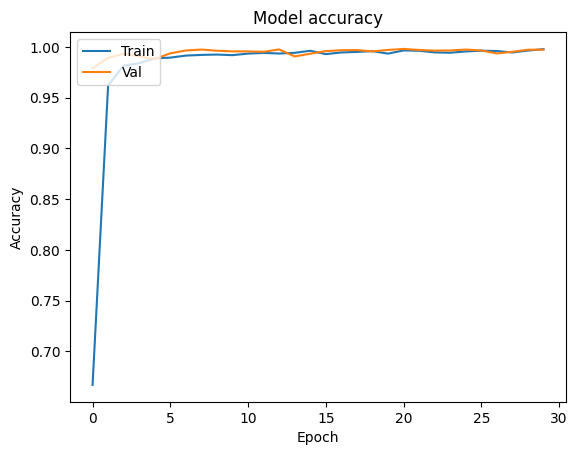

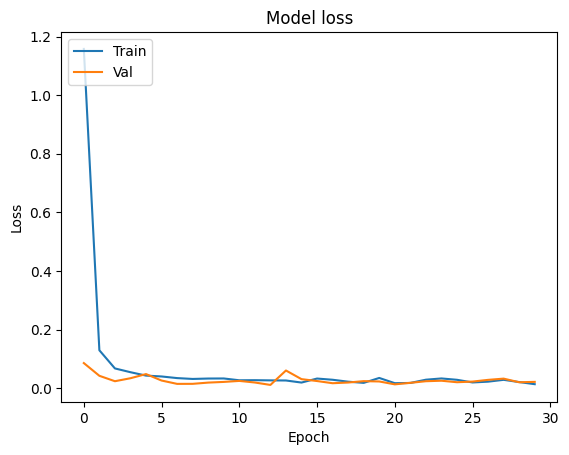

In [20]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [21]:
test = pd.read_csv('/content/Test.csv')

y_test = test["ClassId"].values
imgs = test["Path"].values

data=[]

with tf.device('/GPU:0'):
    for img in imgs:
        image = Image.open('/content/'+img)
        image = image.resize([img_height, img_width])
        data.append(np.array(image))

X_test=np.array(data)

In [22]:
model = tf.keras.models.load_model('best_model.h5')

In [23]:
X_test = X_test/255
model_predict = model.predict(X_test)

correct_predict = []
incorrect_predict = []

for i in range(len(model_predict)):
  label = np.argmax(model_predict[i])
  if label == y_test[i]:
    correct_predict.append(i)
  else:
    incorrect_predict.append(i)

Accuracy = len(correct_predict) / (len(correct_predict) + len(incorrect_predict))
print('Accuracy: {}'.format(Accuracy))

395/395 [==============================] - 1s 3ms/step
Accuracy: 0.9745051464766429


### Model with only data augmentation

In [24]:
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomRotation(
                        factor=0.1,
                        fill_mode="constant"), # Don't want to do too extreme rotation and want to avoid flipping
        tf.keras.layers.RandomZoom(0.15),
        tf.keras.layers.RandomHeight(0.1),
        tf.keras.layers.RandomWidth(0.1),
        tf.keras.layers.Resizing(img_height, img_width),
    ]
)

In [25]:
model_2 = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(img_height, img_width, 3)),
    data_augmentation,
    
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'), 
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
    
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'),
    tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(rate=0.5),

    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(rate=0.5),
    
    tf.keras.layers.Dense(43, activation='softmax')
])

In [26]:
model_2.compile(
  optimizer='adam',
  loss='sparse_categorical_crossentropy',
  metrics=['accuracy'])

In [27]:
checkpoint_callback_2 = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_model_2.h5',
    monitor='val_loss',
    save_best_only=True
)

In [28]:
with tf.device('/GPU:0'):
  history = model_2.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=30, callbacks=[checkpoint_callback_2])

Epoch 1/30
981/981 [==============================] - 13s 10ms/step - loss: 2.1086 - accuracy: 0.3684 - val_loss: 0.7858 - val_accuracy: 0.7371
Epoch 2/30
981/981 [==============================] - 10s 10ms/step - loss: 0.6602 - accuracy: 0.7825 - val_loss: 0.1077 - val_accuracy: 0.9709
Epoch 3/30
981/981 [==============================] - 9s 9ms/step - loss: 0.2985 - accuracy: 0.9081 - val_loss: 0.0799 - val_accuracy: 0.9760
Epoch 4/30
981/981 [==============================] - 9s 9ms/step - loss: 0.1974 - accuracy: 0.9392 - val_loss: 0.0478 - val_accuracy: 0.9864
Epoch 5/30
981/981 [==============================] - 10s 10ms/step - loss: 0.1550 - accuracy: 0.9540 - val_loss: 0.0436 - val_accuracy: 0.9885
Epoch 6/30
981/981 [==============================] - 9s 10ms/step - loss: 0.1262 - accuracy: 0.9626 - val_loss: 0.0461 - val_accuracy: 0.9870
Epoch 7/30
981/981 [==============================] - 9s 9ms/step - loss: 0.1162 - accuracy: 0.9664 - val_loss: 0.0255 - val_accuracy: 0.9932

In [29]:
model_2 = tf.keras.models.load_model('best_model_2.h5')

In [30]:
test_2 = pd.read_csv('/content/Test.csv')

y_test_2 = test_2["ClassId"].values
imgs = test_2["Path"].values

data=[]

with tf.device('/GPU:0'):
    for img in imgs:
        image = Image.open('/content/'+img)
        image = image.resize([img_height, img_width])
        data.append(np.array(image))

X_test_2=np.array(data)

In [31]:
model_2_predict = model_2.predict(X_test_2)

correct_predict = []
incorrect_predict = []

for i in range(len(model_2_predict)):
  label = np.argmax(model_2_predict[i])
  if label == y_test_2[i]:
    correct_predict.append(i)
  else:
    incorrect_predict.append(i)

Accuracy = len(correct_predict) / (len(correct_predict) + len(incorrect_predict))
print('Accuracy: {}'.format(Accuracy))

395/395 [==============================] - 1s 2ms/step
Accuracy: 0.9417260490894696


### Model with only class weights 

In [32]:
from keras.utils import np_utils
from sklearn.utils.class_weight import compute_class_weight

train_labels_one_hot = np_utils.to_categorical(labels)
class_weights = compute_class_weight(class_weight="balanced",
                                     classes = np.unique(labels),
                                     y = labels)
class_weight_dict = dict(enumerate(class_weights))

print('Class Weights:', class_weight_dict)


Class Weights: {0: 4.342081949058693, 1: 0.41073748166771423, 2: 0.4052609819121447, 3: 0.6466930562427841, 4: 0.46052384308198263, 5: 0.49023505876469115, 6: 2.1710409745293466, 7: 0.6332202842377261, 8: 0.6466930562427841, 9: 0.620297421294099, 10: 0.45365035288672917, 11: 0.6907857646229739, 12: 0.4342081949058693, 13: 0.4221468561584841, 14: 1.1690220632081096, 15: 1.447360649686231, 16: 2.1710409745293466, 17: 0.8214749633354285, 18: 0.7598643410852713, 19: 4.342081949058693, 20: 2.5328811369509046, 21: 2.7631430584918957, 22: 2.3380441264162193, 23: 1.7879160966712266, 24: 3.3771748492678726, 25: 0.6078914728682171, 26: 1.5197286821705427, 27: 3.7993217054263564, 28: 1.6885874246339363, 29: 3.3771748492678726, 30: 2.0263049095607237, 31: 1.1690220632081096, 32: 3.7993217054263564, 33: 1.3234212036318223, 34: 2.1710409745293466, 35: 0.7598643410852713, 36: 2.3380441264162193, 37: 4.342081949058693, 38: 0.44050106729580946, 39: 3.0394573643410854, 40: 2.5328811369509046, 41: 3.7993

In [33]:
model_3 = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(img_height, img_width, 3)),
    
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'), 
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
    
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'),
    tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(rate=0.5),

    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(rate=0.5),
    
    tf.keras.layers.Dense(43, activation='softmax')
])

In [34]:
model_3.compile(
  optimizer='adam',
  loss='sparse_categorical_crossentropy',
  metrics=['accuracy'])

In [35]:
checkpoint_callback_3 = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_model_3.h5',
    monitor='val_loss',
    save_best_only=True
)

In [36]:
with tf.device('/GPU:0'):
  history = model_3.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=30, callbacks=[checkpoint_callback_3], class_weight=class_weight_dict)

Epoch 1/30
981/981 [==============================] - 11s 9ms/step - loss: 2.2841 - accuracy: 0.3360 - val_loss: 0.4796 - val_accuracy: 0.8732
Epoch 2/30
981/981 [==============================] - 7s 8ms/step - loss: 0.4145 - accuracy: 0.8526 - val_loss: 0.1138 - val_accuracy: 0.9727
Epoch 3/30
981/981 [==============================] - 8s 8ms/step - loss: 0.1733 - accuracy: 0.9397 - val_loss: 0.0686 - val_accuracy: 0.9802
Epoch 4/30
981/981 [==============================] - 8s 8ms/step - loss: 0.1165 - accuracy: 0.9611 - val_loss: 0.0690 - val_accuracy: 0.9813
Epoch 5/30
981/981 [==============================] - 8s 8ms/step - loss: 0.1029 - accuracy: 0.9669 - val_loss: 0.0403 - val_accuracy: 0.9889
Epoch 6/30
981/981 [==============================] - 8s 8ms/step - loss: 0.0800 - accuracy: 0.9755 - val_loss: 0.0440 - val_accuracy: 0.9881
Epoch 7/30
981/981 [==============================] - 8s 8ms/step - loss: 0.0631 - accuracy: 0.9802 - val_loss: 0.0534 - val_accuracy: 0.9871
Epoch

In [37]:
model_3 = tf.keras.models.load_model('best_model_3.h5')

In [38]:
test_3 = pd.read_csv('/content/Test.csv')

y_test_3 = test_3["ClassId"].values
imgs = test_3["Path"].values

data=[]

with tf.device('/GPU:0'):
    for img in imgs:
        image = Image.open('/content/'+img)
        image = image.resize([img_height, img_width])
        data.append(np.array(image))

X_test_3=np.array(data)

In [39]:
X_test_3 = X_test_3/255
model_3_predict = model_3.predict(X_test_3)

correct_predict = []
incorrect_predict = []

for i in range(len(model_3_predict)):
  label = np.argmax(model_3_predict[i])
  if label == y_test_3[i]:
    correct_predict.append(i)
  else:
    incorrect_predict.append(i)

Accuracy = len(correct_predict) / (len(correct_predict) + len(incorrect_predict))
print('Accuracy: {}'.format(Accuracy))

395/395 [==============================] - 1s 2ms/step
Accuracy: 0.9755344418052256


### Model with both data augmentation and class weights


In [40]:
model_4 = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(img_height, img_width, 3)),
    data_augmentation,
    
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'), 
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
    
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'),
    tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(rate=0.5),

    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(rate=0.5),
    
    tf.keras.layers.Dense(43, activation='softmax')
])

In [41]:
model_4.compile(
  optimizer='adam',
  loss='sparse_categorical_crossentropy',
  metrics=['accuracy'])

In [42]:
checkpoint_callback_4 = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_model_4.h5',
    monitor='val_loss',
    save_best_only=True
)

In [43]:
with tf.device('/GPU:0'):
  history = model_4.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=30, callbacks=[checkpoint_callback_4], class_weight=class_weight_dict)

Epoch 1/30
981/981 [==============================] - 14s 10ms/step - loss: 2.6811 - accuracy: 0.2283 - val_loss: 1.2498 - val_accuracy: 0.5501
Epoch 2/30
981/981 [==============================] - 10s 10ms/step - loss: 1.1376 - accuracy: 0.6028 - val_loss: 0.5508 - val_accuracy: 0.8184
Epoch 3/30
981/981 [==============================] - 10s 10ms/step - loss: 0.6205 - accuracy: 0.7780 - val_loss: 0.2262 - val_accuracy: 0.9199
Epoch 4/30
981/981 [==============================] - 10s 10ms/step - loss: 0.4005 - accuracy: 0.8513 - val_loss: 0.1455 - val_accuracy: 0.9535
Epoch 5/30
981/981 [==============================] - 9s 10ms/step - loss: 0.3014 - accuracy: 0.8902 - val_loss: 0.1813 - val_accuracy: 0.9463
Epoch 6/30
981/981 [==============================] - 9s 9ms/step - loss: 0.2602 - accuracy: 0.9055 - val_loss: 0.0846 - val_accuracy: 0.9748
Epoch 7/30
981/981 [==============================] - 9s 10ms/step - loss: 0.2346 - accuracy: 0.9152 - val_loss: 0.0607 - val_accuracy: 0.9

In [44]:
model_4 = tf.keras.models.load_model('best_model_4.h5')

In [45]:
test_4 = pd.read_csv('/content/Test.csv')

y_test_4 = test_4["ClassId"].values
imgs = test_4["Path"].values

data=[]

with tf.device('/GPU:0'):
    for img in imgs:
        image = Image.open('/content/'+img)
        image = image.resize([img_height, img_width])
        data.append(np.array(image))

X_test_4=np.array(data)

In [48]:
model_4_predict = model_4.predict(X_test_4)

correct_predict = []
incorrect_predict = []

for i in range(len(model_4_predict)):
  label = np.argmax(model_4_predict[i])
  if label == y_test_4[i]:
    correct_predict.append(i)
  else:
    incorrect_predict.append(i)

Accuracy = len(correct_predict) / (len(correct_predict) + len(incorrect_predict))
print('Accuracy: {}'.format(Accuracy))

395/395 [==============================] - 2s 4ms/step
Accuracy: 0.8488519398258115
